Цель: знакомство с теоретическими основами кластеризации данных, 
формирование навыков решения задачи кластеризации с помощью языка 
программирования Python.
Задачи: 
Выполнение практической работы предполагает решение следующий 
задач:
1. Предварительная обработка исходных данных
2. Построение моделей кластеризации данных
3. Подбор оптимальных параметров моделей
4. Оценка качества построенных моделей

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score 
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA

Данные датасетов

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

y_train = df_train['Churn']
df_train = df_train.drop(columns=["Churn"])
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3169.0,2658.504891,1536.114959,1.00,1330.0,2635.0,4027.00,5279.00
ClientPeriod,3169.0,31.855790,24.471827,0.00,8.0,28.0,54.00,72.00
MonthlySpending,3169.0,65.157715,29.921808,18.25,39.2,70.7,89.85,118.65
IsSeniorCitizen,3169.0,0.162512,0.368978,0.00,0.0,0.0,0.00,1.00


In [6]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2113.0,2613.496924,1507.949804,0.0,1313.0,2647.00,3895.0,5281.00
ClientPeriod,2113.0,33.208708,24.651116,0.0,9.0,30.00,56.0,72.00
MonthlySpending,2113.0,64.575367,30.558194,18.8,33.6,70.15,90.3,118.75
IsSeniorCitizen,2113.0,0.154756,0.361758,0.0,0.0,0.00,0.0,1.00


In [7]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3169 non-null   int64  
 1   ClientPeriod              3169 non-null   int64  
 2   MonthlySpending           3169 non-null   float64
 3   TotalSpent                3169 non-null   object 
 4   Sex                       3169 non-null   object 
 5   IsSeniorCitizen           3169 non-null   int64  
 6   HasPartner                3169 non-null   object 
 7   HasChild                  3169 non-null   object 
 8   HasPhoneService           3169 non-null   object 
 9   HasMultiplePhoneNumbers   3169 non-null   object 
 10  HasInternetService        3169 non-null   object 
 11  HasOnlineSecurityService  3169 non-null   object 
 12  HasOnlineBackup           3169 non-null   object 
 13  HasDeviceProtection       3169 non-null   object 
 14  HasTechS

Обработка данных

In [8]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

categorical_features = df_train.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(df_train[categorical_features])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df_train = pd.concat([df_train, df_encoded], axis=1)
df_train.drop(categorical_features, axis=1, inplace=True)
df_train.info()

categorical_features = df_test.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(df_test[categorical_features])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df_test = pd.concat([df_test, df_encoded], axis=1)
df_test.drop(categorical_features, axis=1, inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Columns: 3057 entries, id to PaymentMethod_Mailed check
dtypes: float64(3054), int64(3)
memory usage: 73.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2113 entries, 0 to 2112
Columns: 2101 entries, id to PaymentMethod_Mailed check
dtypes: float64(2098), int64(3)
memory usage: 33.9 MB


Нормализация и стандартизация данных

In [9]:
min_max_train_scaler = MinMaxScaler()
standard_train_scaler = StandardScaler()

normalized_data = min_max_train_scaler.fit_transform(df_train)
df_train = pd.DataFrame(normalized_data, columns=df_train.columns)

normalized_data = min_max_train_scaler.fit_transform(df_test)
df_test = pd.DataFrame(normalized_data, columns=df_test.columns)

standard_data = standard_train_scaler.fit_transform(df_train)
df_train = pd.DataFrame(standard_data, columns=df_train.columns)

standard_data = standard_train_scaler.fit_transform(df_test)
df_test = pd.DataFrame(standard_data, columns=df_test.columns)

df_train.head()

,id,ClientPeriod,MonthlySpending,IsSeniorCitizen,TotalSpent_100.2,TotalSpent_100.25,TotalSpent_100.35,TotalSpent_100.9,TotalSpent_1004.35,TotalSpent_1005.7,...,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.341579,-0.157585,-1.499401,-0.440507,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,...,1.931282,-0.805483,1.931282,-0.810284,-0.490217,1.81977,0.812423,1.881519,-0.725092,-0.531485
1,0.346054,-0.811502,0.544581,-0.440507,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,...,-0.517791,1.241491,-0.517791,-0.810284,-0.490217,-0.54952,0.812423,-0.531485,1.379135,-0.531485
2,1.664523,-0.280195,-1.504415,-0.440507,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,...,1.931282,-0.805483,1.931282,-0.810284,-0.490217,-0.54952,0.812423,-0.531485,-0.725092,1.881519
3,-0.772528,0.741550,0.145144,-0.440507,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,...,-0.517791,-0.805483,-0.517791,1.234135,-0.490217,1.81977,-1.230886,-0.531485,-0.725092,-0.531485
4,1.142344,0.291982,1.206410,2.270110,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,-0.017767,...,-0.517791,1.241491,-0.517791,1.234135,-0.490217,-0.54952,0.812423,-0.531485,1.379135,-0.531485


Выбор наилучших признаков

In [10]:
selector = SelectKBest(score_func=f_classif, k=20)
df_train_selected = selector.fit_transform(df_train, y_train)
selected_features_indices = selector.get_support(indices=True)
selected_feature_names = df_train.columns[selected_features_indices].tolist()
df_test = df_test[selected_feature_names]

Kmeans

In [11]:
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(df_train)


print("Kmeans")
ars = adjusted_rand_score(y_train, labels)
print(f"Adjusted Rand Score: {ars}")

amis = adjusted_mutual_info_score(y_train, labels)
print(f"Adjusted Mutual Info Score: {amis}")

homo_score = homogeneity_completeness_v_measure(y_train, labels)
print(f"Homogenity Competiveness V-Meassure Score: {homo_score}")

sil_score = silhouette_score(df_train, labels)
print(f"Silhoette score: {sil_score}")


Kmeans
Adjusted Rand Score: -0.00040334613913790184
Adjusted Mutual Info Score: -0.00029384814586036375
Homogenity Competiveness V-Meassure Score: (0.0001680853270010333, 0.033995535673577174, 0.00033451669131745736)
Silhoette score: 0.012149638060270898


Agglomerative Clustering

In [12]:
agglomerative_cluster = AgglomerativeClustering(n_clusters=2)
labels = agglomerative_cluster.fit_predict(df_train)

print("Agglomerative Clustering")
ars = adjusted_rand_score(y_train, labels)
print(f"Adjusted Rand Score: {ars}")

amis = adjusted_mutual_info_score(y_train, labels)
print(f"Adjusted Mutual Info Score: {amis}")

homo_score = homogeneity_completeness_v_measure(y_train, labels)
print(f"Homogenity Competiveness V-Meassure Score: {homo_score}")

sil_score = silhouette_score(df_train, labels)
print(f"Silhoette score: {sil_score}")

Agglomerative Clustering
Adjusted Rand Score: -0.05824208783655461
Adjusted Mutual Info Score: 0.03786900713079797
Homogenity Competiveness V-Meassure Score: (0.036460103435589516, 0.03999079808077231, 0.03814392258499871)
Silhoette score: -0.009263909228529984


Правило локтя для Kmeans

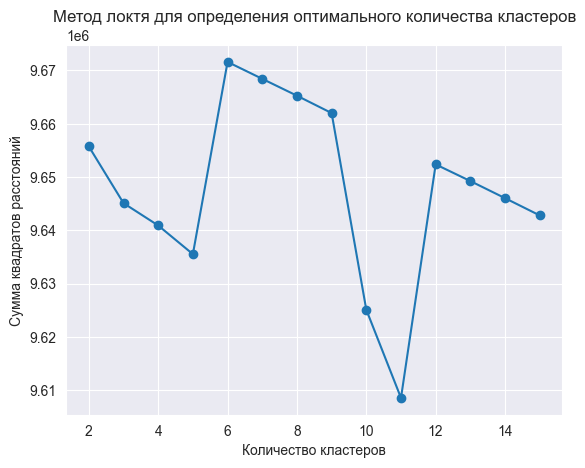

Оптимальное количество кластеров: 11
Adjusted Mutual Info Score: 0.0746449805861366
Adjusted Rand Score: 0.016989066156234068
Homogenity Competiveness V-Meassure Score: (0.036460103435589516, 0.03999079808077231, 0.03814392258499871)
Silhouette score: 0.010495523529842458


In [13]:
sse = []
rand_scores = []
slt_scores = []
homo_scores = []
mutual_rand_scores = []

k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_train)
    sse.append(kmeans.inertia_)
    kmeans_pred = kmeans.predict(df_train)
    rand_scores.append(adjusted_rand_score(y_train, kmeans_pred))
    slt_scores.append(silhouette_score(df_train, kmeans_pred))
    mutual_rand_scores.append(adjusted_mutual_info_score(y_train, kmeans_pred))
    homo_scores.append(homogeneity_completeness_v_measure(y_train, kmeans_pred))

# Строим график суммы квадратов расстояний от количества кластеров
plt.plot(k_range, sse, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.show()

optimal_k_means = k_range[np.argmax(rand_scores)]
print("Оптимальное количество кластеров:", optimal_k_means)
print(f"Adjusted Mutual Info Score: {max(mutual_rand_scores)}")
print(f"Adjusted Rand Score: {max(rand_scores)}")
print(f"Homogenity Competiveness V-Meassure Score: {homo_score}")
print(f"Silhouette score: {max(slt_scores)}")

Правило локтя для Agglomerative Clustering

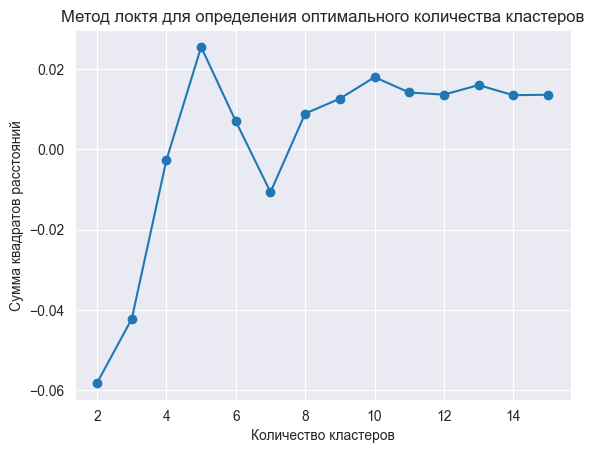

Оптимальное количество кластеров: 5
Adjusted Mutual Info Score: 0.06867559451016593
Adjusted Rand Score: 0.02559047465681461
Homogenity Competiveness V-Meassure Score: (0.036460103435589516, 0.03999079808077231, 0.03814392258499871)
Silhouette score: -0.008963960722861725


In [14]:
rand_scores = []
slt_scores = []
homo_scores = []
mutual_rand_scores = []

k_range = range(2, 16)

for k in k_range:
    agg_model = AgglomerativeClustering(n_clusters=k)
    agg_model.fit(df_train)
    agg_model_pred = agg_model.labels_
    rand_scores.append(adjusted_rand_score(y_train, agg_model_pred))
    slt_scores.append(silhouette_score(df_train, agg_model_pred))
    mutual_rand_scores.append(adjusted_mutual_info_score(y_train, agg_model_pred))
    homo_scores.append(homogeneity_completeness_v_measure(y_train, agg_model_pred))

# Строим график суммы квадратов расстояний от количества кластеров
plt.plot(k_range, rand_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Метод локтя для определения оптимального количества кластеров')
plt.show()

optimal_k_agg = k_range[np.argmax(rand_scores)]
print("Оптимальное количество кластеров:", optimal_k_agg)
print(f"Adjusted Mutual Info Score: {max(mutual_rand_scores)}")
print(f"Adjusted Rand Score: {max(rand_scores)}")
print(f"Homogenity Competiveness V-Meassure Score: {homo_score}")
print(f"Silhouette score: {max(slt_scores)}")

Визуализация Kmeans с помощью PCA

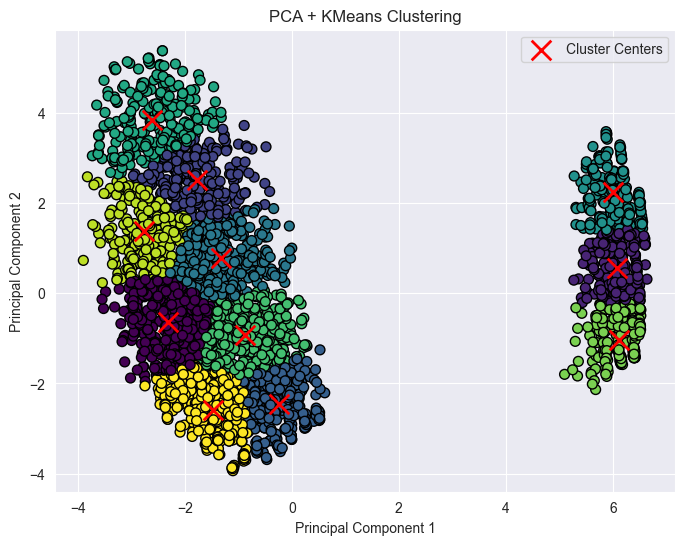

In [15]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_train)

# Кластеризация методом KMeans
kmeans = KMeans(n_clusters=optimal_k_means, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_

# Визуализация результатов
plt.figure(figsize=(8, 6))

# Визуализация точек данных
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Визуализация центров кластеров
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=2, label='Cluster Centers')

plt.title('PCA + KMeans Clustering')
plt.legend()
plt.show()


Визуализация AgglomerativeClustering с помощью PCA

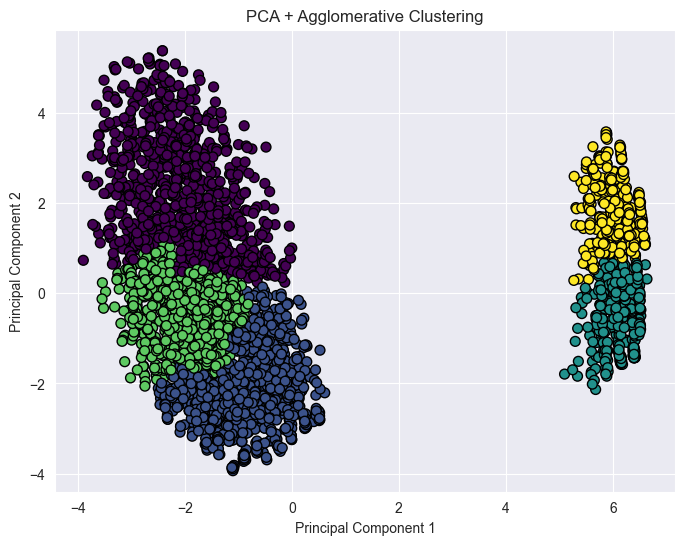

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_train)

# Кластеризация методом AgglomerativeClustering
agg_model = AgglomerativeClustering(n_clusters=optimal_k_agg)
labels = agg_model.fit_predict(X_pca) 

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('PCA + Agglomerative Clustering')
plt.show()

In [18]:
y_pred_test = agg_model.fit_predict(df_test)
df_test_for_id = pd.read_csv('test.csv', encoding='utf_8')
test_id = df_test_for_id['id']

# Создаем DataFrame для результатов
results_df = pd.DataFrame()
results_df['id'] = test_id
results_df['Churn'] = y_pred_test

# Если есть пропущенные значения, заполняем их
results_df['Churn'].fillna(0, inplace=True)

# Сохраняем результаты в CSV файл
results_df.to_csv('sample_submission.csv', index=False)


C:\Users\sagop\AppData\Local\Temp\ipykernel_18240\1829876640.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df['Churn'].fillna(0, inplace=True)
